In [1]:
import numpy as np
import pandas as pd
import random as rnd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn import preprocessing


import sklearn
import re
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train.sample(3)
combine = [data_train, data_test]
data_train.info()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:442: DeprecationWarning: invalid escape sequence \ 
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mlab.py:2210: DeprecationWarning: invalid escape sequence \ 
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mlab.py:2892: DeprecationWarning: invalid escape sequence \|
  delete = set("""~!@#$%^&*()-=+~\|]}[{';: /?.>,<""")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:190: DeprecationWarning: invalid escape sequence \S
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:515: DeprecationWarning: invalid escape sequence \ 
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mathtext.py:78: DeprecationWarning: invalid escape sequence \p
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mathtext.py:442: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mathtext.py:474: DeprecationWar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:261: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:379: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1660: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1844: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:2017: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:2161: DeprecationWarning:

invalid escape sequence \s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\omp.py:349: DeprecationWarning:

invalid escape sequence \g



In [2]:
#convert Sex into integer (Categorical)
Sex_mapping = {'female': 1, 'male': 0}
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( Sex_mapping ).astype(int)

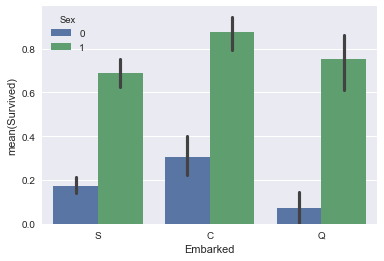

In [3]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

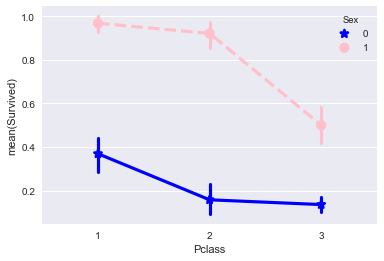

In [4]:
#Class is Relevant
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={0: "blue", 1: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

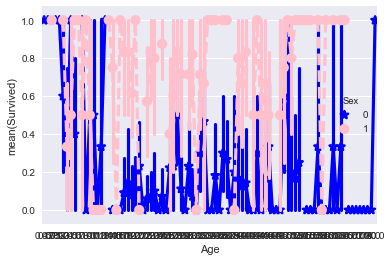

In [5]:
#I need to organize the Age, look:
sns.pointplot(x="Age", y="Survived", hue="Sex", data=data_train,
              palette={0:"blue", 1 :"pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [6]:
#Fill in Age based on Sex and Pclass
def fill_na_age(df_train, df_test):
    #FILL IN AGE BASED ON CORRELATION WITH OTHER VARIABLES
    combine = [df_train, df_test]
    guess_ages = np.zeros((2,3))
    for dataset in combine:
        for i in range(0, 2): #POSSIBLE SEX 0 and 1
            for j in range(0, 3): #Possible Pclass 0, 1, 2
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()
                #guess_df is a dataframe with one column (Age) and only the rows having Sex == i, Pclass == j+1
                #         .dropna() drops all the entries with Na values in the variable Sex
            
                age_mean = guess_df.mean()
                age_std = guess_df.std()
                age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                #age_guess = guess_df.median()

                # Convert random age float to nearest .5 age and save it in the table guess_ages
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
        for i in range(0, 2):
            for j in range(0, 3):
                #for all entries of dataset returning true to Age.isnull() and with sex == i and Pclass == j + 1
                #      the value of the column Age is set to guess_ages[i,j]
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)
    return (df_train, df_test)
(data_train, data_test) = fill_na_age(data_train, data_test)

    

In [7]:
#Organise age in bins
def simplify_ages(df_train, df_test):
    #I want compute the bins into which divide  Age Goups
    Age_Statistic_workspace = pd.concat([df_train['Age'], df_test['Age']])
    #Age_Statistic_workspace= Age_Statistic_workspace.dropna()
    
    #Creates the Bins into which divide the age (Age_quantiles) and the labels (q) expressing to which quantile they correspond
    q = [0, 0.2, 0.4, 0.6, 0.8, 1]
    Age_quantiles = Age_Statistic_workspace.quantile(q)
    Age_quantiles = Age_quantiles.tolist()
    q = ['<= ' + str(x) for x in Age_quantiles]

    del q[0]
    #correct lower bound
    Age_quantiles[0] = Age_quantiles[0] - 0.01
    #Modify 'Age' to the categorical variable obtained by division into Bins
    Age_train = df_train['Age']
    Age_test = df_test['Age']
    #Age_train = Age_train.fillna(-1)
    #Age_test = Age_test.fillna(-1)
    df_train.Age = pd.cut(Age_train, Age_quantiles, labels = q)
    df_test.Age = pd.cut(Age_test, Age_quantiles, labels = q)

    return (df_train, df_test)

(data_train, data_test) = simplify_ages(data_train, data_test)


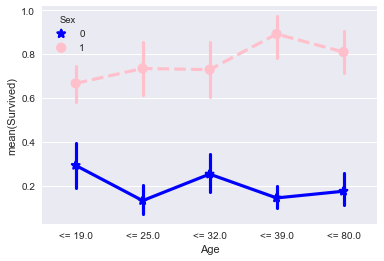

In [8]:
#Lets see what we accomplished reorganizing Age
sns.pointplot(x="Age", y="Survived", hue="Sex", data=data_train,
              palette={0: "blue", 1: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

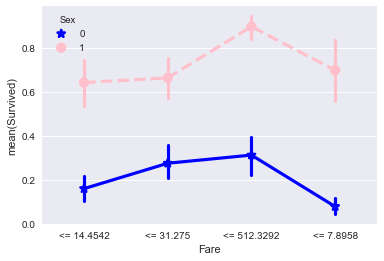

In [9]:
#Organise Fare in bins
def simplify_fares(df_train, df_test):
    df_train.Fare[ df_train.Fare.isnull()] = df_train.Fare.mean()
    df_test.Fare[ df_test.Fare.isnull()] = df_train.Fare.mean()
    
    #I want compute the bins into which divide  Fare Goups
    fare_workspace = pd.concat([df_train['Fare'], df_test['Fare']])
    
    #Creates the Bins into which divide the Fare and Labels. We use quartiles here
    q = [0, 0.25, 0.5, 0.75, 1]
    fare_quartiles = fare_workspace.quantile(q)
    fare_quartiles = fare_quartiles.tolist()
    #correct lower bound
    fare_quartiles[0] = fare_quartiles[0] - 0.01
    q = ['<= ' + str(x) for x in fare_quartiles]
    del q[0]
    
    #Modify 'Fare' to the categorical variable obtained by division into Bins
    Fare_train = df_train['Fare']
    Fare_test = df_test['Fare']
    df_train.Fare = pd.cut(Fare_train, fare_quartiles, labels = q)
    df_test.Fare = pd.cut(Fare_test, fare_quartiles, labels = q)

    return (df_train, df_test)

(data_train, data_test) = simplify_fares(data_train, data_test)

#Lets see what we accomplished reorganizing Fare
sns.pointplot(x="Fare", y="Survived", hue="Sex", data=data_train,
              palette={0: "blue", 1: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [10]:
#Convert fare bins into categorical integers
Fare_mapping = {'<= 7.8958':0, '<= 14.4542': 1, '<= 31.275': 2, '<= 512.3292' :3}
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].map( Fare_mapping ).astype(int)

In [11]:
#NON NULL CABINS, FOR INFERENCE PORPUOSE
inference_cabin = pd.concat([data_train, data_test])
inference_cabin = inference_cabin.dropna(subset= ['Cabin'])
cabins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
inference_cabin.Cabin = inference_cabin.Cabin.apply(lambda x : x[0])
inference_cabin.Cabin.sample(10)

393    D
853    D
456    E
196    E
166    E
81     C
689    B
716    C
59     B
715    F
Name: Cabin, dtype: object

In [12]:
#I want ot infer Cabin first letter from Pclass and Fare as a mode
n = 4 #NUMBER OF FARE BINS
m = 3 #NUMBER OF CLASSES
guesses = [['' for x in range(m)] for y in range(n)]

#COMPUTE THE MODES
for i in range(n) : 
    #i indexes the fares
    for j in range(m): 
        # j+1 indexes the Pclass from 1 to 3
        guess_df = inference_cabin[(inference_cabin.Fare == i) & (inference_cabin.Pclass == j+1)]['Cabin'].dropna()
        guess_df = guess_df.mode()
        if(guess_df.empty):
            guess_df = inference_cabin[(inference_cabin.Pclass == j+1)]['Cabin'].dropna()
            guess_df = guess_df.mode()
        guesses[i][j] = guess_df[0]
for i in range(n) : 
    #i indexes the fares
    for j in range(m): 
        # j+1 indexes the Pclass from 1 to 3
        data_train.loc[ (data_train.Fare == i) & (data_train.Pclass == j+1) & (data_train.Cabin.isnull()), 'Cabin'] = guesses[i][j]
        data_test.loc[ (data_test.Fare == i) & (data_test.Pclass == j+1) & (data_test.Cabin.isnull()), 'Cabin'] = guesses[i][j]
data_train.Cabin = data_train.Cabin.apply(lambda x : x[0])
data_test.Cabin = data_test.Cabin.apply(lambda x : x[0])

data_train.Cabin.head()
#ABBIAMO INFERITO LE CABIN!!

0    F
1    C
2    E
3    C
4    E
Name: Cabin, dtype: object

In [13]:
data_train[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)    

,Cabin,Survived
3,D,0.757576
1,B,0.714286
2,C,0.556701
0,A,0.466667
4,E,0.339394
5,F,0.317536
6,G,0.284404
7,T,0.000000


In [14]:
#We go faster and less detailed on Embarked
#Fill in missing values for Embarked with the Mode
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)    

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [15]:

freq_port = data_train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)    

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [16]:
#Sibilings and Children
data_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)    

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


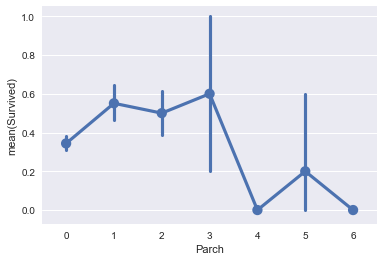

In [17]:
sns.pointplot(x="Parch", y="Survived",  data=data_train);

In [18]:
data_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)    

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


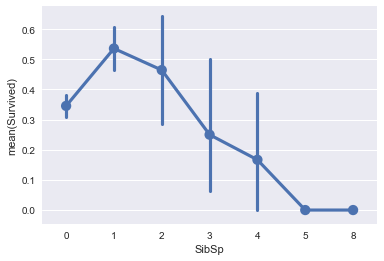

In [19]:
sns.pointplot(x = 'SibSp', y = 'Survived', data = data_train)
data_train['Relatives'] = data_train['SibSp'] + data_train['Parch'] + 1
data_test['Relatives'] = data_test['SibSp'] + data_test['Parch'] + 1


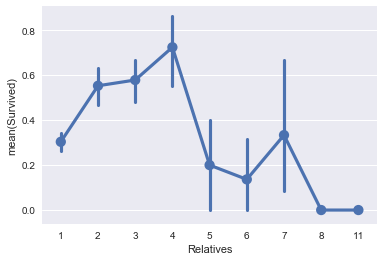

In [20]:
sns.pointplot(x = 'Relatives', y = 'Survived', data = data_train)

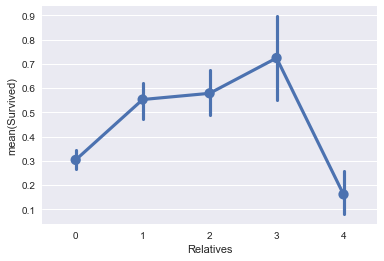

In [21]:
#We simplify the information on the relatives as follows
for dataset in combine:    
    dataset.loc[dataset['Relatives'] == 1, 'Relatives'] = 0
    dataset.loc[dataset['Relatives'] == 2, 'Relatives'] = 1
    dataset.loc[dataset['Relatives'] == 3, 'Relatives'] = 2
    dataset.loc[dataset['Relatives'] == 4, 'Relatives'] = 3
    dataset.loc[dataset['Relatives'] > 4, 'Relatives'] = 4
sns.pointplot(x = 'Relatives', y = 'Survived', data = data_train)

In [22]:
#We are left to deal with the Name.
data_train.Name.sample(10)

246       Lindahl, Miss. Agda Thorilda Viktoria
755                   Hamalainen, Master. Viljo
300    Kelly, Miss. Anna Katherine "Annie Kate"
832                              Saad, Mr. Amin
508                    Olsen, Mr. Henry Margido
714                       Greenberg, Mr. Samuel
638      Panula, Mrs. Juha (Maria Emilia Ojala)
240                       Zabour, Miss. Thamine
861                 Giles, Mr. Frederick Edward
640                      Jensen, Mr. Hans Peder
Name: Name, dtype: object

In [23]:
combine = [data_train, data_test]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data_train['Title'], data_train['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [24]:
#Group rare Titles ---> Rare and alternatives to common titles together
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
data_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [25]:
data_train =data_train.drop(['PassengerId', 'Parch', 'SibSp', 'Ticket', 'Name'], axis =1)
data_test =data_test.drop(['Parch', 'SibSp', 'Ticket', 'Name'], axis =1)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int32
Age          891 non-null category
Fare         891 non-null int32
Cabin        891 non-null object
Embarked     891 non-null object
Relatives    891 non-null int64
Title        891 non-null object
dtypes: category(1), int32(2), int64(3), object(3)
memory usage: 49.9+ KB


In [26]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Title', 'Relatives', 'Pclass', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Relatives,Title
0,0,2,0,1,0,5,2,1,2
1,1,0,1,3,3,2,0,1,3
2,1,2,1,2,1,4,2,0,1
3,1,0,1,3,3,2,2,1,3
4,0,2,0,3,1,4,2,0,2


In [27]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null int64
Fare         891 non-null int64
Cabin        891 non-null int64
Embarked     891 non-null int64
Relatives    891 non-null int64
Title        891 non-null int64
dtypes: int64(9)
memory usage: 62.7 KB


In [28]:
#We prepare a random Forest Model
X_all = data_train.drop("Survived", axis=1)
Y_all = data_train["Survived"]
X_pred  = data_test.drop("PassengerId", axis=1).copy()

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=num_test, random_state=72)

#A straight Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_all, Y_all)
random_forest.score(X_all, Y_all)
acc_random_forest = round(random_forest.score(X_all, Y_all) * 100, 2)
acc_random_forest

91.019999999999996

In [29]:
#Good, but we cand do better with a random forest
#Choose the type of classifier. 

clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [10, 50, 100], 
              'max_features': ['log2', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
#Accuracy on training data
acc_clf = round(clf.score(X_train, y_train) * 100, 2)
acc_clf

82.019999999999996

In [31]:
#Accuracy on Validation Data
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.815642458101


In [32]:
#Kfold Cross test
def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_tr, X_ts = X_all.values[train_index], X_all.values[test_index]
        y_tr, y_ts = Y_all.values[train_index], Y_all.values[test_index]
        clf.fit(X_tr, y_tr)
        predictions = clf.predict(X_ts)
        accuracy = accuracy_score(y_ts, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 
print('Grid Searched RandomForest')
run_kfold(clf)

Grid Searched RandomForest
Fold 1 accuracy: 0.8333333333333334
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8539325842696629
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.797752808988764
Fold 8 accuracy: 0.7752808988764045
Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.8426966292134831
Mean Accuracy: 0.8271535580524343


In [33]:
print('Not - Grid Searched RandomForest')
run_kfold(random_forest)

Not - Grid Searched RandomForest
Fold 1 accuracy: 0.7888888888888889
Fold 2 accuracy: 0.8426966292134831
Fold 3 accuracy: 0.7528089887640449
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8651685393258427
Fold 6 accuracy: 0.8202247191011236
Fold 7 accuracy: 0.8202247191011236
Fold 8 accuracy: 0.7752808988764045
Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.8539325842696629
Mean Accuracy: 0.823832709113608


In [34]:
#Lets Make Predictions
ids = data_test['PassengerId']


Y_pred_noGrid = random_forest.predict(X_pred)
Y_pred_grid = clf.predict(X_pred)
output_noGrid = pd.DataFrame({ 'PassengerId' : ids, 'Survived': Y_pred_noGrid })
output_Grid = pd.DataFrame({ 'PassengerId' : ids, 'Survived': Y_pred_grid })
output_noGrid.to_csv('Third_Pred_noGrid.csv', index = False)
output_Grid.to_csv('Third_Pred_Grid.csv', index = False)



In [35]:
#here I start reading about ensambling
import sklearn
import re
import xgboost as xgb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

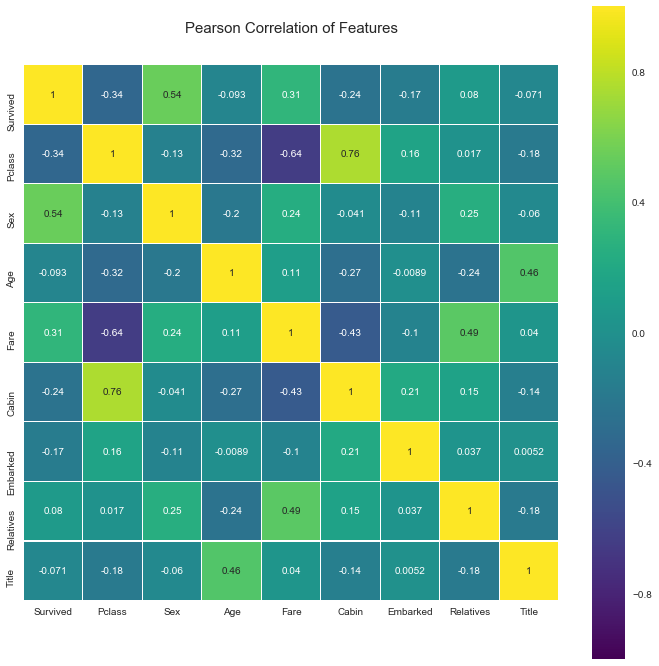

In [36]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

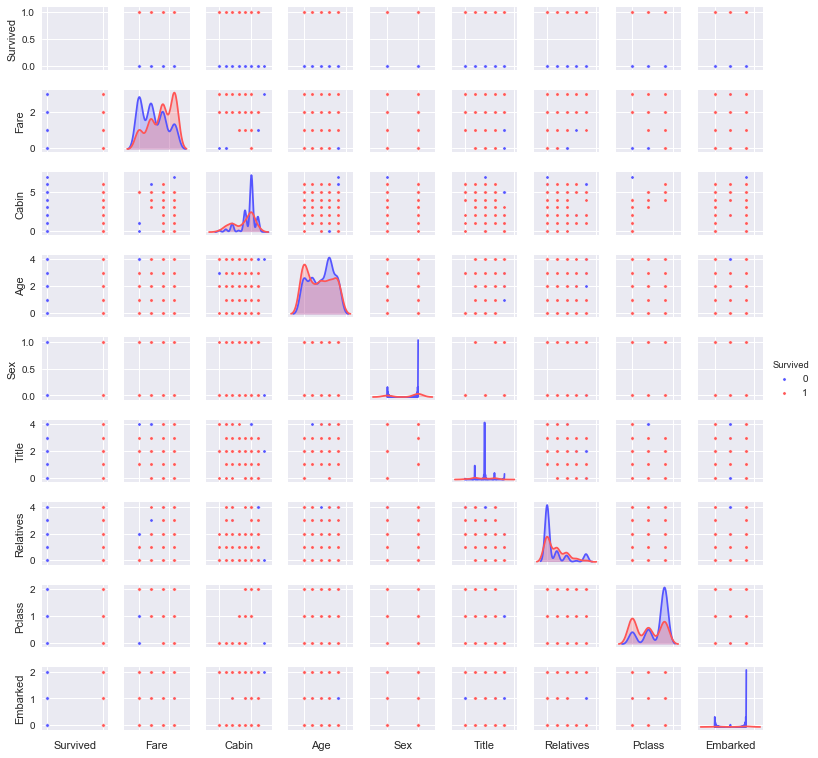

In [37]:
g = sns.pairplot(data_train[[u'Survived', u'Fare', u'Cabin', u'Age', u'Sex', u'Title', u'Relatives', u'Pclass', u'Embarked']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [38]:
# Some useful parameters which will come in handy later on
ntrain = data_train.shape[0]
ntest = data_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        #print (self.clf.fit(x,y).feature_importances_)
        return self.clf.feature_importances_
    
# Class to extend XGboost classifer

In [39]:
#GET OUT-OF-FOLD Predictions:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    #This class trains clf on a kfold split defined by the global variables
    #ntrain and ntest
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    #oof_test contains the average over the K different split-train of the result on the x_test
    #I.E. on the original unknown cases
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [40]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    #'compute_importances':True
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    #'compute_importances':True
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    #'compute_importances':True
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    #'compute_importances':True
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [41]:
# Create 5 objects that represent our 5 models
#we use the Helpers Class SklearnHelper
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [42]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
train = data_train #keep intact the data_* datasets
test = data_test
PassengerId = test['PassengerId']
test = test.drop(['PassengerId'], axis = 1)
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [43]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [44]:
rf_feature = (rf.feature_importances(x_train,y_train)).tolist()
et_feature = (et.feature_importances(x_train, y_train)).tolist()
ada_feature = (ada.feature_importances(x_train, y_train)).tolist()
gb_feature = (gb.feature_importances(x_train,y_train)).tolist()

In [45]:
rf_feature

[0.13917433544458743,
 0.3067790629845519,
 0.05598344396750398,
 0.09825409677931475,
 0.0852001365529288,
 0.03667222384393946,
 0.09349558421993422,
 0.18444111620723946]

In [46]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [47]:
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.260,0.136044,0.067219,0.139174,Pclass
1,0.012,0.432941,0.055706,0.306779,Sex
2,0.032,0.053005,0.248098,0.055983,Age
3,0.174,0.073260,0.143302,0.098254,Fare
4,0.400,0.049562,0.120275,0.085200,Cabin
5,0.006,0.037878,0.156192,0.036672,Embarked
6,0.074,0.073778,0.148536,0.093496,Relatives
7,0.042,0.143532,0.060672,0.184441,Title


In [48]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [49]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.260,0.136044,0.067219,0.139174,Pclass,0.150609
1,0.012,0.432941,0.055706,0.306779,Sex,0.201856
2,0.032,0.053005,0.248098,0.055983,Age,0.097272
3,0.174,0.073260,0.143302,0.098254,Fare,0.122204
4,0.400,0.049562,0.120275,0.085200,Cabin,0.163759
5,0.006,0.037878,0.156192,0.036672,Embarked,0.059186
6,0.074,0.073778,0.148536,0.093496,Relatives,0.097453
7,0.042,0.143532,0.060672,0.184441,Title,0.107661


In [50]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [51]:
#We want to use these models as 'Features' of new one
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [52]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [53]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [54]:
x_train

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [55]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [56]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)